In [20]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
# import pandas_datareader as web
# from datetime import datetime
from datetime import datetime, timedelta
import requests

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import metrics
import optuna
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.metrics import mean_squared_error



**Data Collection using the Weather API**

I realized that the open-meteo weather API is 7 days behind meaning it has NaN values 7 days back the current data.

In [21]:

url = "https://archive-api.open-meteo.com/v1/archive"
# subtracting 7 days from the current date in order to get days with actual values
today_7 = (datetime.today() -timedelta(days=7)).strftime('%Y-%m-%d')

cities = [
    { "name": "Karachi", "country": "Pakistan", "latitude": 24.8608, "longitude": 67.0104 }
]
cities_df =[]
for city in cities:
    params = {"latitude":city["latitude"],
            "longitude":city['longitude'],
            "start_date": "2010-01-01",
            "end_date": today_7,
            "daily": "weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,shortwave_radiation_sum,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration",
            "timezone": "GMT",
            "min": "2010-01-01",
            "max": today_7,
    }
    res = requests.get(url, params=params)

    data = res.json()
    #print(data)
    df = pd.DataFrame(data["daily"])
    df["latitude"] = data["latitude"]
    df["longitude"] = data["longitude"]
    df["elevation"] = data["elevation"]
    df["country"] = city["country"]
    df["city"] = city["name"]
    cities_df.append(df)
data = pd.concat(cities_df, ignore_index=True)
data.tail()

,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,shortwave_radiation_sum,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city
4977,2023-08-18,51,29.8,25.2,27.0,31.0,26.1,28.3,2023-08-18T01:07,2023-08-18T14:04,21.22,0.1,0.1,0.0,1.0,37.8,57.2,266,4.76,24.900002,67.0,8.0,Pakistan,Karachi
4978,2023-08-19,3,29.8,25.0,26.9,32.2,27.0,28.9,2023-08-19T01:07,2023-08-19T14:03,20.96,0.0,0.0,0.0,0.0,30.7,47.2,267,4.59,24.900002,67.0,8.0,Pakistan,Karachi
4979,2023-08-20,53,29.4,24.8,26.8,31.8,26.6,29.1,2023-08-20T01:08,2023-08-20T14:02,17.93,1.0,1.0,0.0,4.0,27.7,41.0,268,4.13,24.900002,67.0,8.0,Pakistan,Karachi
4980,2023-08-21,51,29.6,25.1,27.0,32.2,27.4,29.3,2023-08-21T01:08,2023-08-21T14:01,19.48,0.3,0.3,0.0,3.0,29.8,45.4,262,4.36,24.900002,67.0,8.0,Pakistan,Karachi
4981,2023-08-22,51,29.6,25.5,27.2,31.1,27.2,29.0,2023-08-22T01:08,2023-08-22T14:00,18.20,0.4,0.4,0.0,4.0,33.2,49.3,249,4.24,24.900002,67.0,8.0,Pakistan,Karachi


In [22]:

data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data.head()

,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,shortwave_radiation_sum,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city
time,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0,26.0,14.8,20.9,24.0,13.4,18.6,2010-01-01T02:16,2010-01-01T12:54,16.25,0.0,0.0,0.0,0.0,18.3,25.6,54,4.38,24.900002,67.0,8.0,Pakistan,Karachi
2010-01-02,2,25.3,15.6,20.5,21.8,13.7,18.1,2010-01-02T02:17,2010-01-02T12:54,9.15,0.0,0.0,0.0,0.0,24.6,35.3,64,3.84,24.900002,67.0,8.0,Pakistan,Karachi
2010-01-03,0,25.0,14.3,19.9,22.8,14.2,18.9,2010-01-03T02:17,2010-01-03T12:55,16.03,0.0,0.0,0.0,0.0,16.6,28.1,312,3.69,24.900002,67.0,8.0,Pakistan,Karachi
2010-01-04,0,25.6,15.0,20.4,23.9,13.7,19.4,2010-01-04T02:17,2010-01-04T12:56,16.32,0.0,0.0,0.0,0.0,14.0,22.7,353,3.63,24.900002,67.0,8.0,Pakistan,Karachi
2010-01-05,0,25.4,16.3,20.7,24.5,16.8,20.7,2010-01-05T02:17,2010-01-05T12:56,16.37,0.0,0.0,0.0,0.0,19.3,29.2,270,3.55,24.900002,67.0,8.0,Pakistan,Karachi


In [23]:
data['precipitation_rate'] = data['precipitation_sum'].div(data['precipitation_hours'])
values = {"precipitation_rate": 0.0}
data.fillna(value=values, inplace=True)


In [24]:
[col for col in data.columns]

['weathercode',
 'temperature_2m_max',
 'temperature_2m_min',
 'temperature_2m_mean',
 'apparent_temperature_max',
 'apparent_temperature_min',
 'apparent_temperature_mean',
 'sunrise',
 'sunset',
 'shortwave_radiation_sum',
 'precipitation_sum',
 'rain_sum',
 'snowfall_sum',
 'precipitation_hours',
 'windspeed_10m_max',
 'windgusts_10m_max',
 'winddirection_10m_dominant',
 'et0_fao_evapotranspiration',
 'latitude',
 'longitude',
 'elevation',
 'country',
 'city',
 'precipitation_rate']

**precipitation_rate**

In [25]:
%%time
n_params = {'n_lookback': 5, 'units': 5, 'activation': 'relu'}
col = 'precipitation_rate'

# Train/Test split to validate before future prediction
y_train = data.loc[:'2023-05-31'][col]
y_test = data.loc['2023-05-31':][col]
y = y_train.values.reshape(-1, 1)
p = y_test.values.reshape(-1, 1)  # This is the test data after May 31 2023


# scale the data
scaler = StandardScaler()
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = n_params['n_lookback'] # length of input sequences (lookback period)

n_forecast = len(y_test)  # length of output sequences (forecast period)

trainX = []
trainY = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    trainX.append(y[i - n_lookback: i])
    trainY.append(y[i: i + n_forecast])

trainX = np.array(trainX)
trainY = np.array(trainY)

model = Sequential()

model.add(LSTM(
          units=n_params['units'],
          activation= n_params['activation'],
          return_sequences=True,
          input_shape=(n_lookback, 1))
      )
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.RootMeanSquaredError()])
model.fit(trainX, trainY, epochs=120, batch_size=32, verbose=0)

# generate the forecasts
X_ = y_train[- n_lookback:]  # last available input sequence
X_ = X_.values.reshape(1, n_lookback, 1)
preds = model.predict(X_).reshape(-1, 1)
preds = scaler.inverse_transform(preds)
k = [i[0] for i in preds]
rmse = np.sqrt(mean_squared_error(y_test.values, k))
print(f'RMSE: {rmse}')

1/1 [==============================] - 1s 985ms/step
RMSE: 0.2690944469578492
CPU times: user 3min 30s, sys: 4.7 s, total: 3min 34s
Wall time: 2min 33s


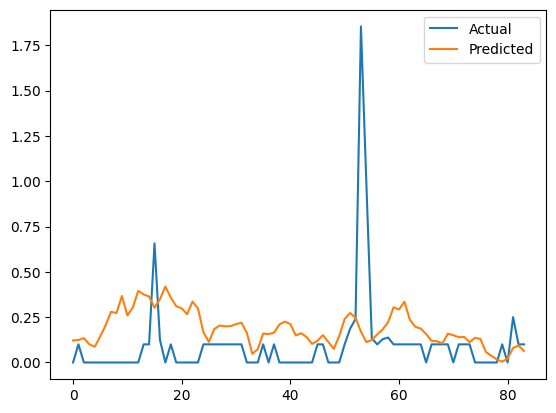

In [26]:
plt.plot(y_test.values, label='Actual')
plt.plot(k, label='Predicted')
plt.legend();

Actual Forecasting for the next 30 Days into the Future

In [27]:
%%time
# Using the entire data for training
y_train = data[col]
y = y_train.values.reshape(-1, 1)


# scale the data
scaler = StandardScaler()
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = n_params['n_lookback'] # length of input sequences (lookback period)

n_forecast = 37  # length of output sequences (forecast period)

trainX = []
trainY = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    trainX.append(y[i - n_lookback: i])
    trainY.append(y[i: i + n_forecast])

trainX = np.array(trainX)
trainY = np.array(trainY)

model = Sequential()

model.add(LSTM(
          units=n_params['units'],
          activation= n_params['activation'],
          return_sequences=True,
          input_shape=(n_lookback, 1))
      )
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.RootMeanSquaredError()])
model.fit(trainX, trainY, epochs=120, batch_size=32, verbose=0)


# generate the forecasts
X_ = y_train[- n_lookback:]  # last available input sequence
X_ = X_.values.reshape(1, n_lookback, 1)
preds = model.predict(X_).reshape(-1, 1)
preds = scaler.inverse_transform(preds)
k = [i[0] for i in preds]


1/1 [==============================] - 1s 656ms/step
CPU times: user 3min 26s, sys: 4.25 s, total: 3min 30s
Wall time: 3min 26s


In [28]:
# Creating the dates for the future(next 30 days)
start = (datetime.strptime(today_7, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
end = (datetime.strptime(today_7, '%Y-%m-%d') + timedelta(days=n_forecast)).strftime('%Y-%m-%d')
ran = pd.date_range(start, end, freq='D')
ran

DatetimeIndex(['2023-08-23', '2023-08-24', '2023-08-25', '2023-08-26',
               '2023-08-27', '2023-08-28', '2023-08-29', '2023-08-30',
               '2023-08-31', '2023-09-01', '2023-09-02', '2023-09-03',
               '2023-09-04', '2023-09-05', '2023-09-06', '2023-09-07',
               '2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
               '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15',
               '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19',
               '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-23',
               '2023-09-24', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28'],
              dtype='datetime64[ns]', freq='D')

In [29]:
forecasted_series = pd.Series(k, index=ran)
forecasted_series

2023-08-23    0.024210
2023-08-24   -0.056600
2023-08-25    0.022762
2023-08-26    0.120877
2023-08-27    0.141871
2023-08-28    0.159256
2023-08-29    0.365910
2023-08-30    0.481904
2023-08-31    0.287073
2023-09-01    0.322222
2023-09-02    0.297373
2023-09-03    0.452522
2023-09-04    0.677993
2023-09-05    0.748184
2023-09-06    0.464715
2023-09-07    0.368622
2023-09-08    0.473952
2023-09-09    0.435336
2023-09-10    0.475566
2023-09-11    0.376460
2023-09-12    0.439862
2023-09-13    0.494849
2023-09-14    0.574464
2023-09-15    0.445744
2023-09-16    0.370600
2023-09-17    0.293122
2023-09-18    0.187061
2023-09-19    0.322646
2023-09-20    0.268909
2023-09-21    0.307176
2023-09-22    0.232574
2023-09-23    0.217601
2023-09-24    0.163726
2023-09-25    0.076788
2023-09-26    0.158455
2023-09-27    0.150193
2023-09-28    0.152368
Freq: D, dtype: float32

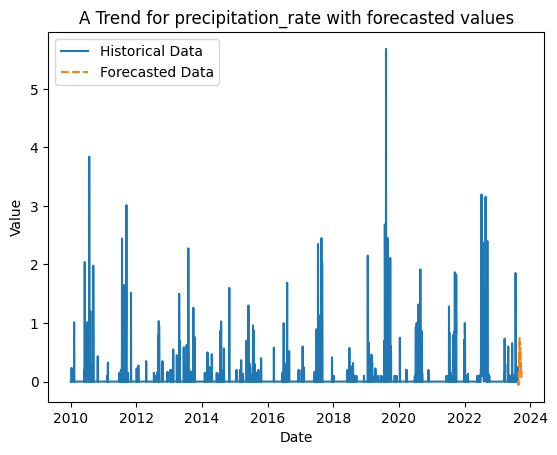

In [30]:
# Creating the Visualizations
plt.plot(data[col].index, data[col].values, label='Historical Data')
plt.plot(forecasted_series.index, forecasted_series.values, linestyle='--', label='Forecasted Data')

# Set the Labels
plt.xlabel('Date')
plt.ylabel('Value')

plt.title(f'A Trend for {col} with forecasted values', fontsize=12)
plt.legend()

**et0_fao_evapotranspiration**

In [31]:
%%time
col = 'et0_fao_evapotranspiration'
n_params = {'n_lookback': 27, 'units': 46, 'activation': 'relu'}

# Train/Test split to validate before future prediction
y_train = data.loc[:'2023-05-31'][col]
y_test = data.loc['2023-05-31':][col]
y = y_train.values.reshape(-1, 1)
p = y_test.values.reshape(-1, 1)  # This is the test data after May 31 2023


# scale the data
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = n_params['n_lookback']

n_forecast = len(y_test)  # length of output sequences (forecast period)

trainX = []
trainY = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    trainX.append(y[i - n_lookback: i])
    trainY.append(y[i: i + n_forecast])

trainX = np.array(trainX)
trainY = np.array(trainY)

model = Sequential()

model.add(LSTM(
          units=n_params['units'],
          activation= n_params['activation'],
          return_sequences=True,
          input_shape=(n_lookback, 1))
      )
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.RootMeanSquaredError()])
model.fit(trainX, trainY, epochs=120, batch_size=32, verbose=0)


# generate the forecasts
X_ = y_train[- n_lookback:]  # last available input sequence
X_ = X_.values.reshape(1, n_lookback, 1)
preds = model.predict(X_).reshape(-1, 1)
preds = scaler.inverse_transform(preds)
k = [i[0] for i in preds]
rmse = np.sqrt(mean_squared_error(y_test.values, k))
print(f'RMSE: {rmse}')

1/1 [==============================] - 1s 600ms/step
RMSE: 0.9489991733221198
CPU times: user 15min 1s, sys: 14.7 s, total: 15min 16s
Wall time: 10min 26s


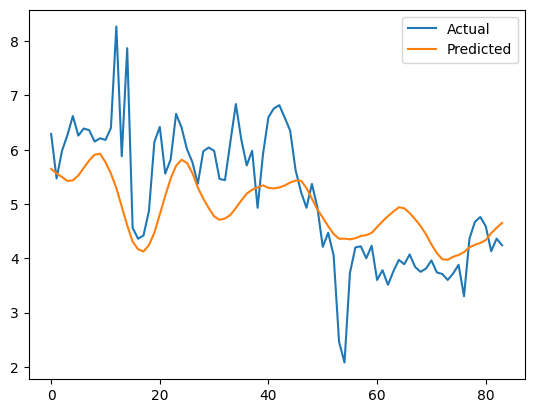

In [32]:
plt.plot(y_test.values, label='Actual')
plt.plot(k, label='Predicted')
plt.legend();

Actually Forecasting for the next 30 Days

In [33]:
%%time
# Using the entire data for training
y_train = data[col]
y = y_train.values.reshape(-1, 1)


# scale the data
scaler = StandardScaler()
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = n_params['n_lookback'] # length of input sequences (lookback period)

n_forecast = 37  # length of output sequences (forecast period)

trainX = []
trainY = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    trainX.append(y[i - n_lookback: i])
    trainY.append(y[i: i + n_forecast])

trainX = np.array(trainX)
trainY = np.array(trainY)

model = Sequential()

model.add(LSTM(
          units=n_params['units'],
          activation= n_params['activation'],
          return_sequences=True,
          input_shape=(n_lookback, 1))
      )
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.RootMeanSquaredError()])
model.fit(trainX, trainY, epochs=120, batch_size=32, verbose=0)

# generate the forecasts
X_ = y_train[- n_lookback:]  # last available input sequence
X_ = X_.values.reshape(1, n_lookback, 1)
preds = model.predict(X_).reshape(-1, 1)
preds = scaler.inverse_transform(preds)
k = [i[0] for i in preds]


1/1 [==============================] - 1s 591ms/step
CPU times: user 16min 54s, sys: 19.6 s, total: 17min 13s
Wall time: 11min 27s


In [34]:
# Creating the dates for the future
start = (datetime.strptime(today_7, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
end = (datetime.strptime(today_7, '%Y-%m-%d') + timedelta(days=n_forecast)).strftime('%Y-%m-%d')
ran = pd.date_range(start, end, freq='D')
ran

DatetimeIndex(['2023-08-23', '2023-08-24', '2023-08-25', '2023-08-26',
               '2023-08-27', '2023-08-28', '2023-08-29', '2023-08-30',
               '2023-08-31', '2023-09-01', '2023-09-02', '2023-09-03',
               '2023-09-04', '2023-09-05', '2023-09-06', '2023-09-07',
               '2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
               '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15',
               '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19',
               '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-23',
               '2023-09-24', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28'],
              dtype='datetime64[ns]', freq='D')

In [35]:
forecasted_series = pd.Series(k, index=ran)
forecasted_series

2023-08-23    6.587197
2023-08-24    7.398044
2023-08-25    7.620352
2023-08-26    7.386891
2023-08-27    6.848449
2023-08-28    6.327380
2023-08-29    5.904055
2023-08-30    5.528944
2023-08-31    5.250492
2023-09-01    5.081629
2023-09-02    5.085809
2023-09-03    5.207114
2023-09-04    5.423083
2023-09-05    5.665909
2023-09-06    5.798513
2023-09-07    5.819567
2023-09-08    5.712963
2023-09-09    5.616112
2023-09-10    5.504038
2023-09-11    5.374621
2023-09-12    5.343396
2023-09-13    5.295216
2023-09-14    5.178499
2023-09-15    5.033341
2023-09-16    4.952506
2023-09-17    4.940323
2023-09-18    4.883531
2023-09-19    4.977008
2023-09-20    5.239271
2023-09-21    5.434884
2023-09-22    5.612060
2023-09-23    5.658033
2023-09-24    5.571696
2023-09-25    5.368251
2023-09-26    5.127222
2023-09-27    4.933920
2023-09-28    4.812874
Freq: D, dtype: float32

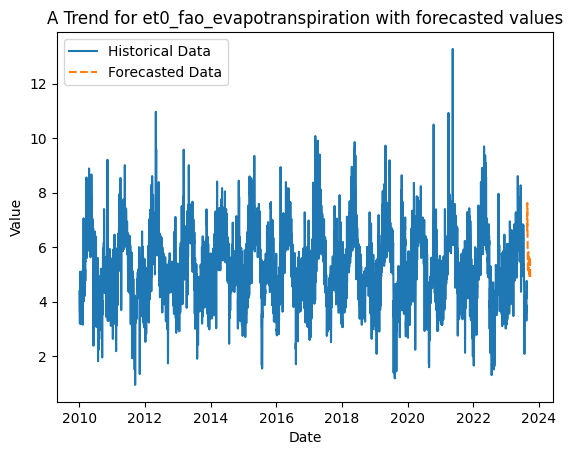

In [36]:
# Creating the Visualizations
plt.plot(data[col].index, data[col].values, label='Historical Data')
plt.plot(forecasted_series.index, forecasted_series.values, linestyle='--', label='Forecasted Data')

# Set the Labels
plt.xlabel('Date')
plt.ylabel('Value')

plt.title(f'A Trend for {col} with forecasted values', fontsize=12)
plt.legend()

## **Conclusion**

I have been able to create a forecasting model to forecast precipitation_rate & evapotranspiration using **LSTM**. This model has been able to forecast the possible values in the next 30 Days into the future.

The next steps moving forward is to to continously improve the model and find parameters that produce a low RMSE bringing our forecasting close to the actual ground values. This is why hyperparameter tuning is very important.

I have been using Optuna to do the tuning, but the one challenge is the training takes way too much time & that's why I didn't include the tuning section. Feel free to let me know if you want the tuning notebook

Happy Forecasting ✈⏰